# 8. gyakorlat RNN és LSTM 

![lstm](https://www.researchgate.net/profile/Mohsen_Fayyaz/publication/306377072/figure/fig2/AS:398082849165314@1471921755580/An-example-of-a-basic-LSTM-cell-left-and-a-basic-RNN-cell-right-Figure-follows-a.ppm)


In [ ]:
import collections
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
batch_size = 64
# Each MNIST image batch is a tensor of shape (batch_size, 28, 28).
# Each input sequence will be of size (28, 28) (height is treated like time).
input_dim = 28

units = 64
output_size = 10  # labels are from 0 to 9

# Build the RNN model
def build_model(allow_cudnn_kernel=True):
  # CuDNN is only available at the layer level, and not at the cell level.
  # This means `LSTM(units)` will use the CuDNN kernel,
  # while RNN(LSTMCell(units)) will run on non-CuDNN kernel.
  if allow_cudnn_kernel:
    # The LSTM layer with default options uses CuDNN.
    lstm_layer = tf.keras.layers.LSTM(units, input_shape=(None, input_dim))
  else:
    # Wrapping a LSTMCell in a RNN layer will not use CuDNN.
    lstm_layer = tf.keras.layers.RNN(
        tf.keras.layers.LSTMCell(units),
        input_shape=(None, input_dim))
  model = tf.keras.models.Sequential([
      lstm_layer,
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dense(output_size)]
  )
  return model

Számjegyek pixelsorai mint szekvenciák: Az MNIST képek egyes sorait fogjuk időbeli sorrendben használni időbélyegként és ez alapján próbáljuk osztályozni a bemeneti egyedeket.

MNIST betöltése

In [ ]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
sample, sample_label = x_train[100], y_train[100]

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
y_test[0:5]

array([7, 2, 1, 0, 4], dtype=uint8)

A veszteségfüggvényünk most a `SparseCategoricalCrossentropy`, amely szerint a címkéink 1D-s integerként szerepelnek.
A kimeneti rétegünkben 10 neuron helyezkedik el.

In [ ]:
model = build_model(allow_cudnn_kernel=True)

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              optimizer='sgd',
              metrics=['accuracy'])

In [ ]:
model.fit(x_train, y_train,
          validation_data=(x_test, y_test),
          batch_size=batch_size,
          epochs=5)

Epoch 1/5
938/938 [==============================] - 23s 22ms/step - loss: 1.3037 - accuracy: 0.5813 - val_loss: 0.4926 - val_accuracy: 0.8506
Epoch 2/5
938/938 [==============================] - 20s 21ms/step - loss: 0.4400 - accuracy: 0.8695 - val_loss: 0.2732 - val_accuracy: 0.9149
Epoch 3/5
938/938 [==============================] - 20s 21ms/step - loss: 0.2751 - accuracy: 0.9168 - val_loss: 0.2126 - val_accuracy: 0.9377
Epoch 4/5
938/938 [==============================] - 20s 22ms/step - loss: 0.2160 - accuracy: 0.9346 - val_loss: 0.1877 - val_accuracy: 0.9412
Epoch 5/5
938/938 [==============================] - 21s 22ms/step - loss: 0.1751 - accuracy: 0.9464 - val_loss: 0.1538 - val_accuracy: 0.9523


Predicted result is: [5], target result is: 5


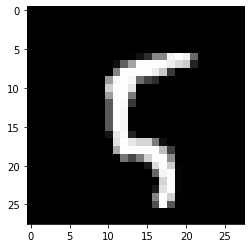

In [ ]:
with tf.device('CPU:0'):
  cpu_model = build_model(allow_cudnn_kernel=True)
  cpu_model.set_weights(model.get_weights())
  result = tf.argmax(cpu_model.predict_on_batch(tf.expand_dims(sample, 0)), axis=1)
  print('Predicted result is: %s, target result is: %s' % (result.numpy(), sample_label))
  plt.imshow(sample, cmap=plt.get_cmap('gray'))

Beágyazás
![Word2vec](http://jalammar.github.io/images/word2vec/word2vec.png)



> src: http://jalammar.github.io/illustrated-word2vec/



In [ ]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
# define documents
docs = ['Well done!',
		'Good work',
		'Great effort',
		'nice work',
		'Excellent!',
		'Weak',
		'Poor effort!',
		'not good',
		'poor work',
		'Could have done better.',]
# define class labels
labels = array([1,1,1,1,1,0,0,0,0,0])
# integer encode the documents
vocab_size = 50
encoded_docs = [one_hot(d, vocab_size) for d in docs]
print(encoded_docs)
# pad documents to a max length of 4 words
max_length = 4
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(padded_docs)
# define the model
model = Sequential()
model.add(Embedding(vocab_size, 8, input_length=max_length))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# summarize the model
print(model.summary())
# fit the model
model.fit(padded_docs[:-1], labels[:-1], epochs=50, verbose=0)
# evaluate the model
loss, accuracy = model.evaluate(padded_docs, labels, verbose=0)
print('Accuracy: %f' % (accuracy*100))


[[29, 14], [13, 23], [23, 27], [40, 23], [12], [44], [19, 27], [40, 13], [19, 23], [40, 24, 14, 16], [31]]
[[29 14  0  0]
 [13 23  0  0]
 [23 27  0  0]
 [40 23  0  0]
 [12  0  0  0]
 [44  0  0  0]
 [19 27  0  0]
 [40 13  0  0]
 [19 23  0  0]
 [40 24 14 16]
 [31  0  0  0]]
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 4, 8)              400       
_________________________________________________________________
flatten_3 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 433
Trainable params: 433
Non-trainable params: 0
_________________________________________________________________
None
Accuracy: 72.727275


In [ ]:
import numpy as np
model.predict(np.expand_dims(padded_docs[-1],0))

array([[0.53352207]], dtype=float32)

In [ ]:
np.expand_dims(padded_docs[0],0)

array([[29, 14,  0,  0]], dtype=int32)